Import the libraries

In [1]:
import sys
import os
import mlflow
import mlflow.sklearn


from pathlib import Path

# sys.path.append(os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
# sys.path.append(str(Path.cwd().parent))

experiment_name = 'CNN_Model_Training_Experiment'

mlflow_dir = "./mlruns"

mlflow_dir = Path(mlflow_dir)

if not os.path.exists(mlflow_dir):
    os.makedirs(mlflow_dir)

mlflow.set_tracking_uri(f"file://{os.path.abspath(mlflow_dir)}")

mlflow.set_experiment(experiment_name)


mlflow.autolog()
mlflow.sklearn.autolog(log_models=True, log_datasets=True)



/media/niteshkumar/SSD_Store_0_nvme/allPythoncodesWithPipEnv/BitsLearning/MLOps_Assignment/Assignment_2/bitsMtech_MLOps_Assignment_2/.mlopsAssignment2Env/lib/python3.12/site-packages/mlflow/tracking/_tracking_service/utils.py:184: FutureWarning: The filesystem tracking backend (e.g., './mlruns') is deprecated as of February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://mlflow.org/docs/latest/self-hosting/migrate-from-file-store for migration guidance.
  return FileStore(store_uri, store_uri)


In [2]:
import torch

# Check if a GPU is available
print(torch.cuda.is_available())

# Get the name of the device
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 3080 Ti


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

# x = torch.tensor([1.0, 2.0, 3.0]).to(device)

# x = torch.tensor([1.0, 2.0, 3.0]).to(device)

# # Any operation now uses CUDA cores
# y = x * 2
# print(y)
import tensorflow as tf
tf.config.optimizer.set_jit(True) # Enables XLA globally

cuda


2026-02-22 22:35:06.352539: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026/02/22 22:35:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2026/02/22 22:35:07 INFO mlflow.tracking.fluent: Autologging successfully enabled for tensorflow.


Load packages

In [4]:
import os
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms

# 1. Device Agnostic Setup (Updated for CUDA and Apple Silicon)
device = (
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)
print(f"Using device: {device}")

# 2. Modern Data Augmentation (Using Recommended Transforms)
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Using device: cuda


In [5]:
lr = 0.001 # learning_rate
batch_size = 100 # we will use mini-batch method
epochs = 10 # How much to train a model


In [6]:
# 1. Modern Device Selection (Includes Apple Silicon Support)
device = (
    "cuda" if torch.cuda.is_available() 
    else "mps" if torch.backends.mps.is_available() 
    else "cpu"
)

# 2. Comprehensive Global Seeding
seed = 1234
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed) # Safe to call even if cuda isn't available
np.random.seed(seed)            # Good practice if using NumPy for data prep

# 3. Optional: Ensure Deterministic Behavior (for strict reproducibility)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

print(f"Active Device: {device}")

Active Device: cuda


In [7]:


# Save datasets path
# train_image_path = "DataFiles/SampleFiles/train/"
# test_image_path = "DataFiles/SampleFiles/test/"

# TRAIN_FOLDER = "DataFiles/SampleFiles/train/"
# TEST_FOLDER =  "DataFiles/SampleFiles/test/"

TRAIN_FOLDER = "DataFiles/train/"
TEST_FOLDER =  "DataFiles/test/"

# train_image_list = os.listdir(train_image_path)[0:SAMPLE_SIZE]
train_image_list = os.listdir(TRAIN_FOLDER)
test_image_list = os.listdir(TEST_FOLDER)

train_image_list = [TRAIN_FOLDER+x for x in train_image_list]
test_image_list = [TEST_FOLDER+x for x in test_image_list]

print(len(train_image_list))
print(len(test_image_list))

# os.listdir(TRAIN_FOLDER)

25000
12500


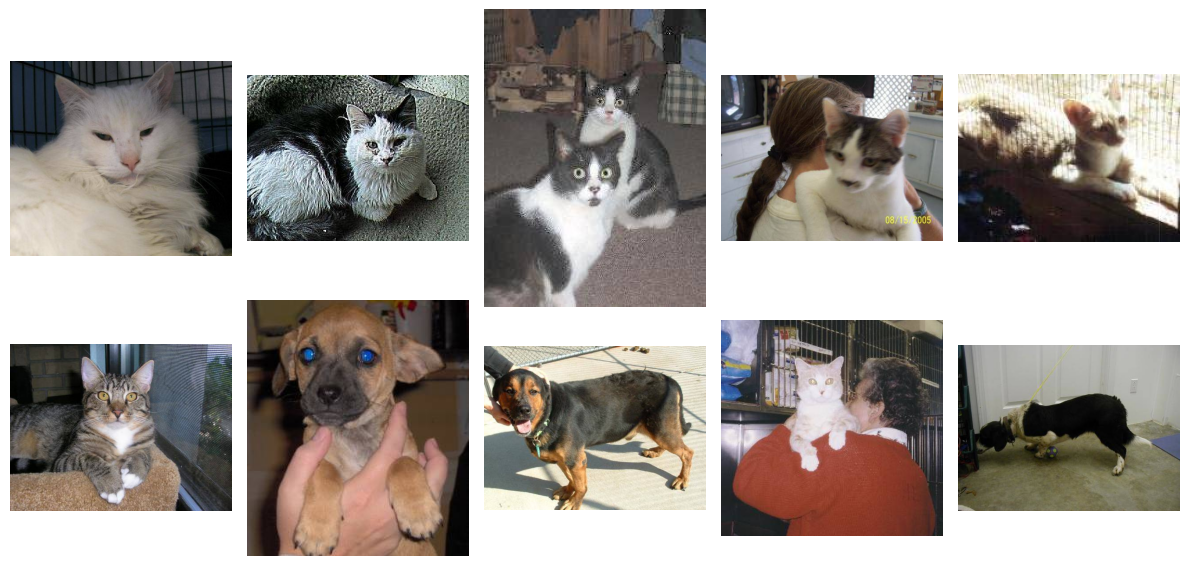

In [8]:
from PIL import Image

# 1. Modern Subplot Generation
fig, axes = plt.subplots(2, 5, figsize=(12, 6))
axes = axes.flatten()  # Flatten the 2x5 array into a 1D list for easy iteration

# 2. Random Index Selection
random_indices = np.random.choice(len(train_image_list), size=10, replace=False)

# 3. Clean Enumerated Loop
for i, idx in enumerate(random_indices):
    img = Image.open(train_image_list[idx])
    axes[i].imshow(img)
    axes[i].axis('off')  # Turn off axis for each specific subplot
    # Optional: axes[i].set_title(f"Index: {idx}", fontsize=8)

plt.tight_layout() # Automatically adjusts spacing
plt.show()

In [9]:
from pathlib import Path
from sklearn.model_selection import train_test_split

# 1. Ensure reproducibility with a fixed seed
# 2. Use stratify if you have imbalanced classes (optional)
train_list, val_list = train_test_split(
    train_image_list, 
    test_size=0.2, 
    random_state=1234,
    shuffle=True
)

print(f"Train size: {len(train_list)}")
print(f"Val size: {len(val_list)}")

Train size: 20000
Val size: 5000


In [10]:
# ImageNet standard normalization values
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

# 1. Training: High Variety
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),      # Resize slightly larger first
    transforms.RandomResizedCrop(224),  # Zoom in on different parts
    transforms.RandomHorizontalFlip(),  # Flip left/right
    transforms.ColorJitter(0.1, 0.1),   # Optional: minor color tweaks
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

# 2. Validation/Test: Consistency is Key
# No random crops or flips here!
val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),      # Just a clean resize
    transforms.CenterCrop(224),        # Ensure the center object is visible
    transforms.ToTensor(),
    transforms.Normalize(norm_mean, norm_std)
])

In [11]:
from pathlib import Path

class ImageDataset(Dataset):
    def __init__(self, file_list, transform=None, is_test=False):
        self.file_list = file_list
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        
        # 1. Open and ensure RGB
        img = Image.open(img_path).convert('RGB')
        
        # 2. Apply transforms
        if self.transform:
            img = self.transform(img)
        
        # 3. Extract ID or Label
        filename = Path(img_path).name.lower()
        
        if self.is_test:
            # For test data, extract numeric ID from filename (e.g., "123.jpg" -> 123)
            file_id = int(filename.split('.')[0])
            return img, file_id
        else:
            # For train/val data, extract label
            if 'dog' in filename:
                label = 1
            elif 'cat' in filename:
                label = 0
            else:
                label = -1 
            return img, label

In [12]:

train_data = ImageDataset(train_list, transform=train_transforms, is_test=False)
val_data   = ImageDataset(val_list,   transform=val_test_transforms, is_test=False)
test_data  = ImageDataset(test_image_list, transform=val_test_transforms, is_test=True)

In [13]:
import os

# 1. Use all available CPU cores for data loading
# This prevents the 'bottleneck' where the GPU waits for the CPU to resize images.
num_cpus = os.cpu_count()

# 2. Modern DataLoader Configuration
loader_args = {
    'batch_size': batch_size,
    'num_workers': num_cpus,
    'pin_memory': True if device != 'cpu' else False
}

# Training: Needs shuffling to prevent the model from learning the order
train_loader = DataLoader(train_data, shuffle=True, **loader_args)

# Validation & Test: Shuffle=False for consistent evaluation
val_loader = DataLoader(val_data, shuffle=False, **loader_args)
test_loader = DataLoader(test_data, shuffle=False, **loader_args)

print(f"Loaders ready using {num_cpus} CPU workers.")

Loaders ready using 32 CPU workers.


In [14]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn, self).__init__()
        
        # Layer 1: 224 -> 55 -> 27
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1), # Added padding=1
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Layer 2: 27 -> 7 -> 3
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Layer 3: 3 -> 1
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            # MaxPool here might make the feature map too small (0 or 1)
        )
        
        # Global Average Pooling is more modern than fixed Linear sizes
        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        
        self.fc1 = nn.Linear(64, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        
        # Modern pooling: ensures the output is always the right size for FC layers
        out = self.adaptive_pool(out)
        out = torch.flatten(out, 1) # Cleaner than out.view()
        
        out = self.relu(self.fc1(out))
        out = self.dropout(out) # Apply dropout during forward pass
        out = self.fc2(out)
        return out

model = Cnn().to(device)

In [15]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (adaptive_pool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features

In [16]:
# 1. Modern Optimizer (AdamW is generally preferred over Adam for better weight decay)
optimizer = optim.AdamW(model.parameters(), lr=0.001)

# 2. Loss Function (Standard for classification)
criterion = nn.CrossEntropyLoss()

# 3. Learning Rate Scheduler (Optional but recommended for "latest" performance)
# Reduces the learning rate if the validation loss stops improving
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)

print(f"Model ready on {device}. Hyperparameters set.")

Model ready on cuda. Hyperparameters set.


In [17]:
epochs = 50
patience = 3
min_delta = 0.0005
best_val_loss = float("inf")
early_stop_counter = 0

# Track metrics per epoch
history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": []
}

for epoch in range(epochs):
    # --- TRAINING PHASE ---
    model.train()
    train_loss, train_acc = 0, 0

    for data, label in train_loader:
        data, label = data.to(device), label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * data.size(0)
        train_acc += (output.argmax(1) == label).sum().item()

    avg_train_loss = train_loss / len(train_loader.dataset)
    avg_train_acc = train_acc / len(train_loader.dataset)

    # --- VALIDATION PHASE ---
    model.eval()
    val_loss, val_acc = 0, 0

    with torch.inference_mode():
        for data, label in val_loader:
            data, label = data.to(device), label.to(device)

            output = model(data)
            loss = criterion(output, label)

            val_loss += loss.item() * data.size(0)
            val_acc += (output.argmax(1) == label).sum().item()

    avg_val_loss = val_loss / len(val_loader.dataset)
    avg_val_acc = val_acc / len(val_loader.dataset)

    # Store history
    history["train_loss"].append(avg_train_loss)
    history["train_acc"].append(avg_train_acc)
    history["val_loss"].append(avg_val_loss)
    history["val_acc"].append(avg_val_acc)

    print(f"Epoch [{epoch+1}/{epochs}]")
    print(f"Train Loss: {avg_train_loss:.4f} | Train Acc: {avg_train_acc:.4f}")
    print(f"Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}\n")

    # --- EARLY STOPPING ---
    if avg_val_loss < best_val_loss - min_delta:
        best_val_loss = avg_val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

Epoch [1/50]
Train Loss: 0.6666 | Train Acc: 0.5886
Val Loss: 0.6389 | Val Acc: 0.6286

Epoch [2/50]
Train Loss: 0.6355 | Train Acc: 0.6306
Val Loss: 0.6070 | Val Acc: 0.6848

Epoch [3/50]
Train Loss: 0.6103 | Train Acc: 0.6684
Val Loss: 0.6995 | Val Acc: 0.5828

Epoch [4/50]
Train Loss: 0.5945 | Train Acc: 0.6863
Val Loss: 0.5718 | Val Acc: 0.7074

Epoch [5/50]
Train Loss: 0.5850 | Train Acc: 0.6888
Val Loss: 0.5866 | Val Acc: 0.6838

Epoch [6/50]
Train Loss: 0.5802 | Train Acc: 0.6963
Val Loss: 0.5507 | Val Acc: 0.7190

Epoch [7/50]
Train Loss: 0.5756 | Train Acc: 0.7012
Val Loss: 0.5209 | Val Acc: 0.7438

Epoch [8/50]
Train Loss: 0.5631 | Train Acc: 0.7117
Val Loss: 0.5614 | Val Acc: 0.7100

Epoch [9/50]
Train Loss: 0.5589 | Train Acc: 0.7157
Val Loss: 0.5076 | Val Acc: 0.7510

Epoch [10/50]
Train Loss: 0.5501 | Train Acc: 0.7154
Val Loss: 0.5080 | Val Acc: 0.7502

Epoch [11/50]
Train Loss: 0.5496 | Train Acc: 0.7210
Val Loss: 0.5890 | Val Acc: 0.6916

Epoch [12/50]
Train Loss: 0.54

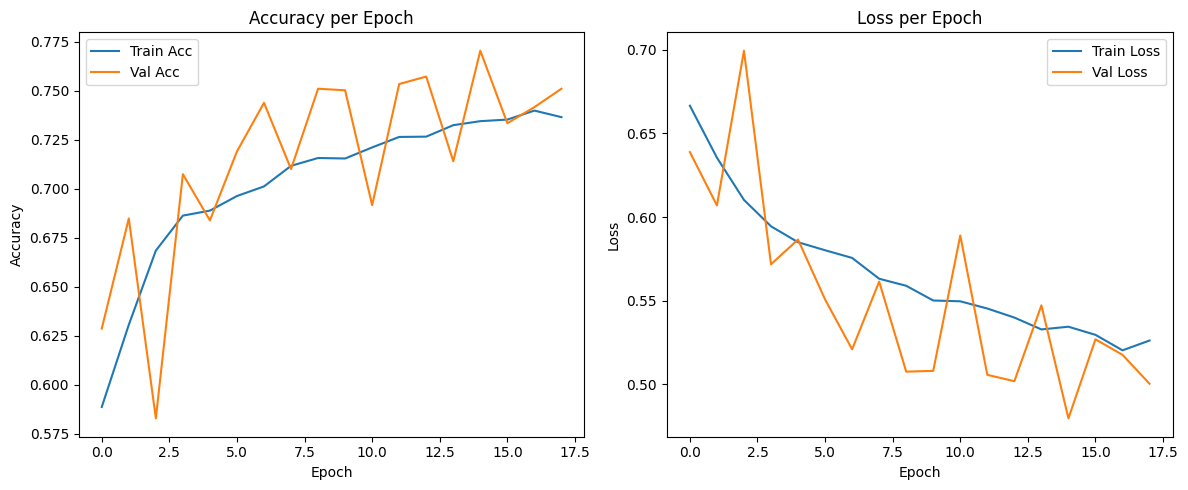

In [18]:
# Plot after training
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Save the trained model (recommended: state_dict)
model_save_path = "artifacts/cnn_model.pt"
os.makedirs("artifacts", exist_ok=True)
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to: {model_save_path}")

# (Optional) Save full model for quick reload without class definition changes
full_model_path = "artifacts/cnn_model_full.pt"
torch.save(model, full_model_path)
print(f"Full model saved to: {full_model_path}")

Model saved to: artifacts/cnn_model.pt
Full model saved to: artifacts/cnn_model_full.pt


In [20]:
model.eval()
dog_probs = []

with torch.inference_mode():
    for data, file_id in test_loader:
        data = data.to(device, non_blocking=True)
        
        logits = model(data)
        probs = logits.softmax(dim=1)[:, 1].cpu().numpy()
        
        # file_id is already a tensor of integers
        file_ids = file_id.cpu().numpy()
        
        # Zip the actual file IDs with probabilities
        dog_probs.extend(zip(file_ids, probs))

In [21]:
dog_probs.sort(key = lambda x : int(x[0]))
dog_probs

[(np.int64(1), np.float32(0.8545927)),
 (np.int64(2), np.float32(0.76745945)),
 (np.int64(3), np.float32(0.10901483)),
 (np.int64(4), np.float32(0.97259605)),
 (np.int64(5), np.float32(0.056008812)),
 (np.int64(6), np.float32(0.29169214)),
 (np.int64(7), np.float32(0.07751387)),
 (np.int64(8), np.float32(0.21560468)),
 (np.int64(9), np.float32(0.34667966)),
 (np.int64(10), np.float32(0.17819741)),
 (np.int64(11), np.float32(0.021483308)),
 (np.int64(12), np.float32(0.9860307)),
 (np.int64(13), np.float32(0.20079805)),
 (np.int64(14), np.float32(0.48988494)),
 (np.int64(15), np.float32(0.08823214)),
 (np.int64(16), np.float32(0.08415116)),
 (np.int64(17), np.float32(0.87985444)),
 (np.int64(18), np.float32(0.8080822)),
 (np.int64(19), np.float32(0.009029013)),
 (np.int64(20), np.float32(0.64303356)),
 (np.int64(21), np.float32(0.58866376)),
 (np.int64(22), np.float32(0.34196854)),
 (np.int64(23), np.float32(0.3401394)),
 (np.int64(24), np.float32(0.5948011)),
 (np.int64(25), np.float32(

In [22]:
idx = [item[0] for item in dog_probs]
prob = [item[1] for item in dog_probs]

In [23]:
# Create the DataFrame directly from the zipped list of tuples
submission = pd.DataFrame(dog_probs, columns=['id', 'label'])

# Ensure 'id' is an integer (common for image filenames like '123.jpg')
# and 'label' is a float32 to save memory
submission['id'] = submission['id'].astype(int)
submission['label'] = submission['label'].astype('float32')

# Sort by ID to ensure a consistent submission format
submission.sort_values('id', inplace=True)

In [24]:
print(submission.head())

   id     label
0   1  0.854593
1   2  0.767459
2   3  0.109015
3   4  0.972596
4   5  0.056009
